In [1]:
#import

import cv2

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import datetime
sns.set()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

%load_ext tensorboard


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [2]:
# check path
path = os.getcwd()
path

'/home/user/AI_HandSign_Number'

In [3]:
# load dataset

X = np.load(path + "/dataset/X.npy")
Y = np.load(path + "/dataset/Y.npy")

print("Samples shape", X.shape)
print("Labels shape", Y.shape)
print("Img shape", X[0].shape)

Samples shape (2062, 64, 64)
Labels shape (2062, 10)
Img shape (64, 64)


In [4]:
# X is already normalize/preprocessed (i.e )

In [5]:
#overwiev datasets, create a new array of correct labels corresponding to the index of the numbers

Y_df = pd.DataFrame(Y)

label=[]
for i in range(0,X.shape[0]):
    if Y_df.loc[i,0]   == 1:
        label.append(9)
    elif Y_df.loc[i,1] == 1:
        label.append(0)
    elif Y_df.loc[i,2] == 1:
        label.append(7)
    elif Y_df.loc[i,3] == 1:
        label.append(6)
    elif Y_df.loc[i,4] == 1:
        label.append(1)
    elif Y_df.loc[i,5] == 1:
        label.append(8)
    elif Y_df.loc[i,6] == 1:
        label.append(4)
    elif Y_df.loc[i,7] == 1:
        label.append(3)
    elif Y_df.loc[i,8] == 1:
        label.append(2)
    elif Y_df.loc[i,9] == 1:
        label.append(5)
        
Y_labels = pd.Series(label)

([], [])

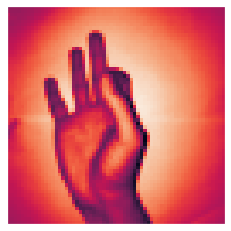

In [6]:
plt.imshow(X[0])
plt.xticks([])
plt.yticks([])

In [7]:
Y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
Y_labels = np.array(Y_labels)
Y_labels

array([9, 9, 9, ..., 5, 5, 5])

In [9]:
# perform one-hot encoding on the new correct labels

def oneHotEncoding(labels):
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return labels

lb = LabelEncoder()
new_Y = oneHotEncoding(Y_labels)
new_Y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

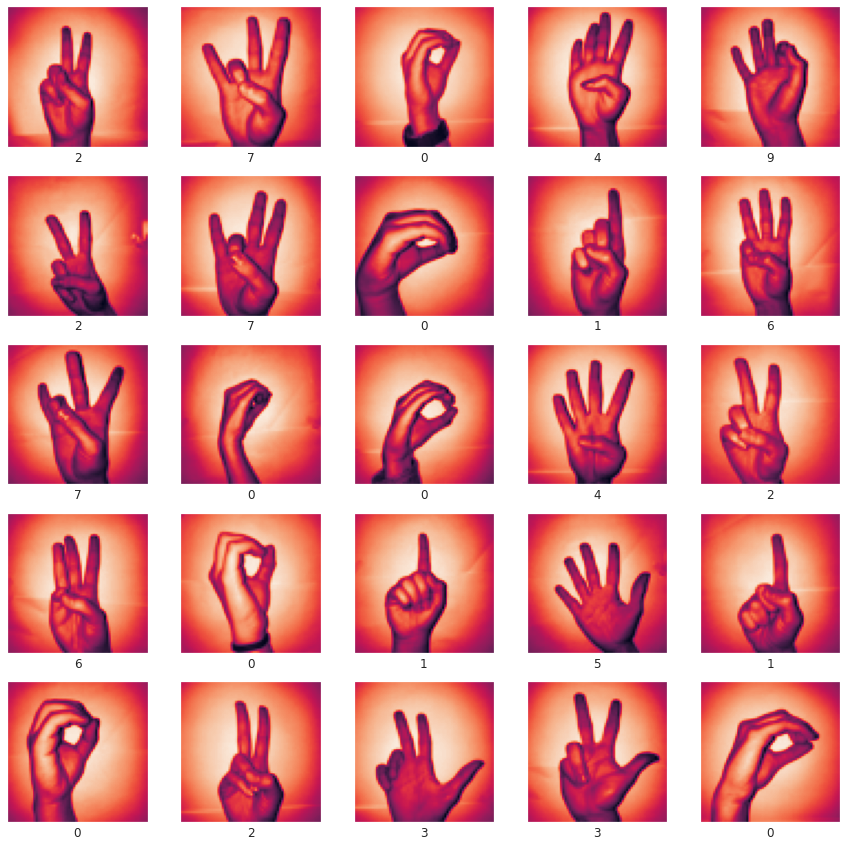

In [10]:
# Plot random samples and corresponding class

plt.figure(figsize=(15,15))
for ii in range(0, 25):
    plt.subplot(5,5,ii+1)
    plt.xticks([])
    plt.yticks([])
    randno = random.randint(0, X.shape[0])
    plt.imshow(X[randno])
    plt.xlabel(Y_labels[randno])

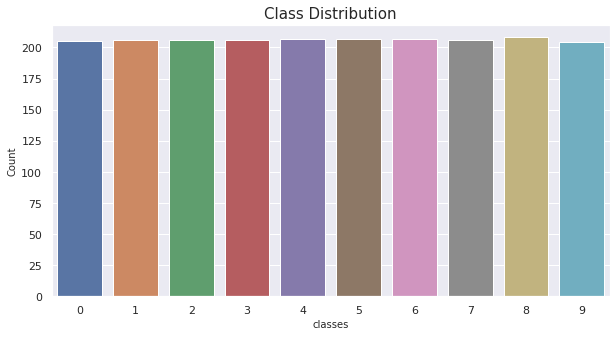

In [11]:
# Check data distribution

plt.figure(figsize=(10,5))

b = sns.countplot(x = Y_labels)
b.axes.set_title('Class Distribution', fontsize = 15)
b.set_xlabel('classes', fontsize = 10)
b.set_ylabel('Count', fontsize = 10)
#print(Y_labels.value_counts())
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,new_Y, test_size=0.20, random_state=42)

X_train = X_train.reshape(-1,64,64,1)
X_test  = X_test.reshape(-1,64,64,1)

print("x_train", X_train.shape)
print("x_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (1649, 64, 64, 1)
x_test (413, 64, 64, 1)
y_train (1649, 10)
y_test (413, 10)


In [21]:
#Create convolutional_model

def convolutional_model(input_img, num_classes, optimizer):
    
    model = Sequential()
    
    # Convolutional layer 1

    model.add(
        Conv2D(
            filters=8,
            kernel_size=(5,5),
            input_shape=input_img,
            activation='relu',
            padding='same',
            name='conv2d_1'
        )
    )
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    
    # Convolutional layer 2

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            name='conv2d_2'
        )
    )
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))
    model.add(Dropout(0.25))
    
    # Convolutional layer 3

    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            name='conv2d_3'
        )
    )
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))
    model.add(Dropout(0.25))
    
    # Convolutional layer 4

    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            name='conv2d_4'
        )
    )
    model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))
    model.add(Dropout(0.25))
       
    
    # Fully Connected Layers

    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation= "relu", name='dense_1'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation= "relu", name='dense_2'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= "softmax", name='out_layer'))
        
    # Compile model
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.summary()
    
    return model

In [22]:
!rm -rf ./logs/
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=15, 
                               verbose=0, 
                               mode='auto',
                               baseline=None, 
                               restore_best_weights=True
)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, tensorboard_callback]

2021-12-29 13:43:44.394081: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 13:43:44.394219: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 13:43:44.396704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [30]:
# Paramaters for training

batch_size  = 32    # batch size of 32 performs the best.
epochs      = 100   # Number of epochs
input_img   = (X_train.shape[1], X_train.shape[2], 1)
num_classes = y_train.shape[1]     # 10 activations in the last layer
optim       = Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-07) #optimizer

In [56]:
model = convolutional_model(input_img, num_classes, optim)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 8)         208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        4672      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [32]:
# Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=10,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.2, # Randomly zoom image 20%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [33]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (X_test,y_test), 
                    callbacks=callbacks[0], steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/100
51/51 [==============================] - 7s 120ms/step - loss: 2.3084 - accuracy: 0.0903 - val_loss: 2.3038 - val_accuracy: 0.0847
Epoch 2/100
51/51 [==============================] - 6s 109ms/step - loss: 2.3012 - accuracy: 0.1070 - val_loss: 2.2978 - val_accuracy: 0.1550
Epoch 3/100
51/51 [==============================] - 6s 116ms/step - loss: 2.2183 - accuracy: 0.1732 - val_loss: 1.8606 - val_accuracy: 0.4116
Epoch 4/100
51/51 [==============================] - 6s 123ms/step - loss: 1.9248 - accuracy: 0.2999 - val_loss: 1.4958 - val_accuracy: 0.5012
Epoch 5/100
51/51 [==============================] - 6s 114ms/step - loss: 1.6295 - accuracy: 0.4069 - val_loss: 1.1034 - val_accuracy: 0.7288
Epoch 6/100
51/51 [==============================] - 8s 149ms/step - loss: 1.3867 - accuracy: 0.5269 - val_loss: 0.7954 - val_accuracy: 0.8426
Epoch 7/100
51/51 [==============================] - 10s 200ms/step - loss: 1.2246 - accuracy: 0.5560 - val_loss: 0.6696 - val_accuracy: 0.835

Epoch 58/100
51/51 [==============================] - 8s 157ms/step - loss: 0.2006 - accuracy: 0.9344 - val_loss: 0.0438 - val_accuracy: 0.9782
Epoch 59/100
51/51 [==============================] - 8s 162ms/step - loss: 0.2212 - accuracy: 0.9456 - val_loss: 0.0363 - val_accuracy: 0.9903
Epoch 60/100
51/51 [==============================] - 8s 159ms/step - loss: 0.1610 - accuracy: 0.9487 - val_loss: 0.0231 - val_accuracy: 0.9952
Epoch 61/100
51/51 [==============================] - 7s 145ms/step - loss: 0.1782 - accuracy: 0.9425 - val_loss: 0.0386 - val_accuracy: 0.9879
Epoch 62/100
51/51 [==============================] - 7s 132ms/step - loss: 0.2095 - accuracy: 0.9344 - val_loss: 0.0204 - val_accuracy: 0.9976
Epoch 63/100
51/51 [==============================] - 6s 113ms/step - loss: 0.1827 - accuracy: 0.9474 - val_loss: 0.0217 - val_accuracy: 0.9927
Epoch 64/100
51/51 [==============================] - 6s 123ms/step - loss: 0.1833 - accuracy: 0.9474 - val_loss: 0.0276 - val_accuracy:

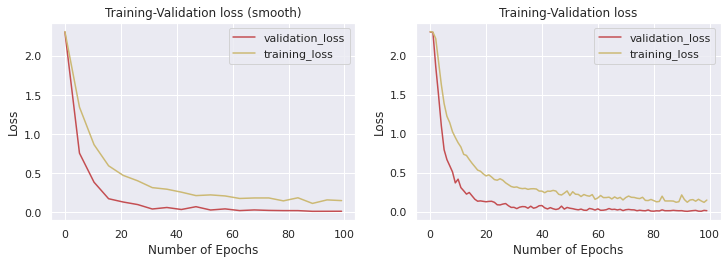

In [34]:
#Evaluate- Loss  (smooth)

from scipy.interpolate import make_interp_spline, BSpline 

n_epochs = len(history.history['loss'])
n_epochs = np.arange(0, n_epochs) # no of valid epochs

xnew = np.linspace(n_epochs.min(), n_epochs.max(), 20)

spl_val_loss = make_interp_spline(n_epochs, history.history["val_loss"], k=3)
spl_loss     = make_interp_spline(n_epochs, history.history["loss"], k=3)

y_smooth_val_loss = spl_val_loss(xnew)
y_smooth_loss     = spl_loss(xnew)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(xnew, y_smooth_val_loss, label="validation_loss", c="r")
plt.plot(xnew, y_smooth_loss, label="training_loss", c="y")
plt.title("Training-Validation loss (smooth)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# evaluate- loss (normal)
plt.subplot(2,2,2)
plt.plot(history.history["val_loss"], label="validation_loss", c="r" )
plt.plot(history.history["loss"], label="training_loss", c="y" )
plt.title("Training-Validation loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

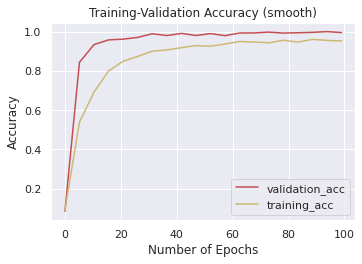

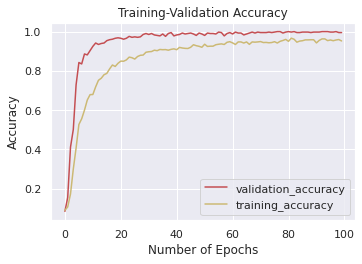

In [35]:
spl_val_acc = make_interp_spline(n_epochs, history.history["val_accuracy"], k=3)
spl_acc = make_interp_spline(n_epochs, history.history["accuracy"], k=3)

y_smooth_val_acc = spl_val_acc(xnew)
y_smooth_acc= spl_acc(xnew)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(xnew, y_smooth_val_acc, label="validation_acc", c="r")
plt.plot(xnew, y_smooth_acc, label="training_acc", c="y")
plt.title("Training-Validation Accuracy (smooth)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
#Evaluate- Accuracy


plt.figure(figsize=(12,8))
plt.subplot(2,2,2)
plt.plot(history.history["val_accuracy"], label="validation_accuracy", c="r")
plt.plot(history.history["accuracy"], label="training_accuracy", c="y")
plt.title("Training-Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
model.evaluate(X_train, y_train)

52/52 [==============================] - 1s 16ms/step - loss: 0.0167 - accuracy: 0.9951


[0.016704749315977097, 0.9951485991477966]

In [39]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 21ms/step - loss: 0.0151 - accuracy: 0.9952


[0.015129582025110722, 0.9951573610305786]

In [40]:
val_losses   = history.history['val_loss']
min_val_loss = min(val_losses) 
index        = val_losses.index(min_val_loss)

In [41]:
Val_acc  = history.history['val_accuracy'][index]
acc      = history.history['accuracy'][index]
loss     = history.history['loss'][index]
val_loss = history.history['val_loss'][index]

In [42]:
#Results
print('Train accuracy of the model: ',acc)
print('Train loss of the model: ',loss)
print('Validation accuracy of the model: ',Val_acc)
print('Validation loss of the model: ',val_loss)

Train accuracy of the model:  0.9628942608833313
Train loss of the model:  0.12346541881561279
Validation accuracy of the model:  1.0
Validation loss of the model:  0.007107109297066927


In [43]:
# make predictions on the testing set
predIdxs = model.predict(X_test, batch_size=batch_size)

(-0.5, 63.5, 63.5, -0.5)

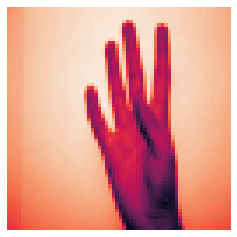

In [44]:
plt.matshow(X_test[0])
plt.axis(False)

In [45]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [46]:
test_y = np.array([np.argmax(ii) for ii in y_test])
test_y

array([4, 5, 6, 5, 9, 8, 2, 7, 8, 5, 1, 5, 3, 0, 6, 6, 9, 8, 9, 3, 9, 2,
       6, 4, 5, 7, 3, 6, 8, 5, 2, 8, 1, 4, 1, 4, 6, 0, 5, 7, 3, 3, 6, 0,
       0, 7, 9, 3, 2, 5, 0, 5, 4, 7, 0, 9, 4, 2, 7, 2, 2, 3, 7, 3, 8, 5,
       7, 6, 4, 1, 0, 0, 8, 3, 1, 5, 5, 1, 6, 2, 2, 5, 7, 9, 5, 9, 9, 1,
       0, 8, 8, 1, 3, 1, 3, 1, 7, 7, 2, 3, 7, 9, 5, 9, 7, 0, 3, 2, 2, 3,
       7, 2, 6, 6, 7, 7, 4, 0, 8, 8, 8, 9, 0, 8, 2, 7, 4, 8, 0, 9, 6, 0,
       5, 5, 2, 6, 2, 5, 7, 7, 7, 4, 7, 4, 4, 0, 4, 7, 8, 1, 5, 7, 0, 7,
       4, 7, 4, 4, 0, 0, 3, 8, 5, 2, 4, 7, 1, 3, 4, 5, 2, 3, 7, 5, 0, 4,
       3, 4, 9, 4, 0, 3, 1, 2, 1, 6, 7, 7, 1, 7, 2, 4, 2, 6, 7, 9, 2, 2,
       2, 8, 1, 3, 9, 2, 7, 1, 7, 8, 8, 2, 5, 9, 7, 2, 8, 6, 0, 6, 8, 9,
       4, 1, 4, 0, 3, 8, 1, 0, 5, 8, 2, 1, 3, 4, 6, 0, 8, 1, 4, 1, 5, 4,
       0, 9, 5, 9, 0, 7, 6, 5, 7, 1, 7, 9, 9, 2, 7, 8, 5, 7, 1, 3, 5, 2,
       6, 3, 6, 3, 3, 0, 0, 0, 2, 5, 8, 3, 3, 6, 0, 3, 8, 6, 4, 5, 0, 5,
       7, 5, 2, 6, 9, 3, 9, 2, 9, 4, 8, 7, 0, 9, 9,

In [47]:
y_predict_labels = np.array([np.argmax(ii) for ii in predIdxs])
y_predict_labels

array([4, 5, 6, 5, 9, 8, 2, 7, 8, 5, 1, 5, 3, 0, 6, 6, 9, 8, 9, 3, 9, 2,
       6, 4, 5, 7, 3, 6, 8, 5, 2, 8, 1, 4, 1, 4, 6, 0, 5, 7, 3, 3, 6, 0,
       0, 7, 9, 3, 2, 5, 0, 5, 4, 7, 0, 9, 4, 2, 7, 2, 2, 3, 7, 3, 8, 5,
       7, 6, 4, 1, 0, 0, 8, 3, 1, 5, 5, 1, 6, 2, 2, 5, 7, 9, 5, 9, 9, 1,
       0, 8, 8, 1, 3, 1, 3, 1, 7, 7, 2, 3, 7, 9, 5, 9, 7, 0, 3, 2, 2, 3,
       7, 2, 6, 6, 7, 7, 4, 0, 8, 8, 8, 9, 0, 8, 2, 7, 4, 8, 0, 9, 6, 0,
       5, 5, 2, 6, 2, 5, 7, 7, 7, 4, 7, 4, 4, 0, 4, 7, 8, 1, 5, 7, 0, 7,
       4, 7, 4, 4, 0, 0, 3, 8, 5, 2, 4, 7, 1, 3, 4, 5, 2, 3, 7, 5, 0, 4,
       3, 4, 9, 4, 0, 3, 1, 2, 0, 6, 7, 7, 1, 7, 2, 4, 2, 6, 7, 9, 2, 2,
       2, 8, 1, 3, 9, 2, 7, 1, 7, 8, 7, 2, 5, 9, 7, 2, 8, 6, 0, 6, 8, 9,
       4, 1, 4, 0, 3, 8, 1, 0, 5, 8, 2, 1, 3, 4, 6, 0, 8, 1, 4, 1, 5, 4,
       0, 9, 5, 9, 0, 7, 6, 5, 7, 1, 7, 9, 9, 2, 7, 8, 5, 7, 1, 3, 5, 2,
       6, 3, 6, 3, 3, 0, 0, 0, 2, 5, 8, 3, 3, 6, 0, 3, 8, 6, 4, 5, 0, 5,
       7, 5, 2, 6, 9, 3, 9, 2, 9, 4, 8, 7, 0, 9, 9,

In [48]:
predIdxs.shape

(413, 10)

Text(66.5, 0.5, 'Truth')

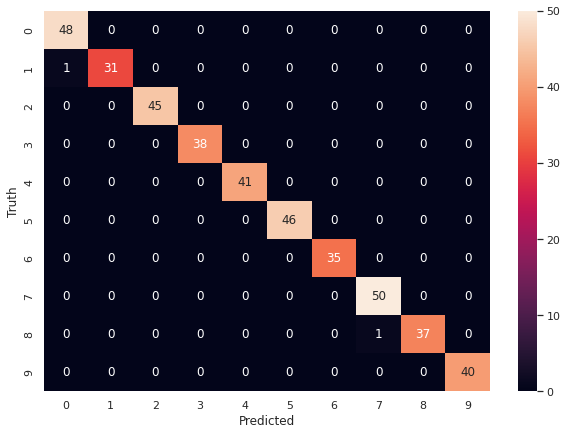

In [49]:
cm = tf.math.confusion_matrix(test_y, y_predict_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(test_y, y_predict_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.97      0.98        32
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        46
           6       1.00      1.00      1.00        35
           7       0.98      1.00      0.99        50
           8       1.00      0.97      0.99        38
           9       1.00      1.00      1.00        40

    accuracy                           1.00       413
   macro avg       1.00      0.99      1.00       413
weighted avg       1.00      1.00      1.00       413



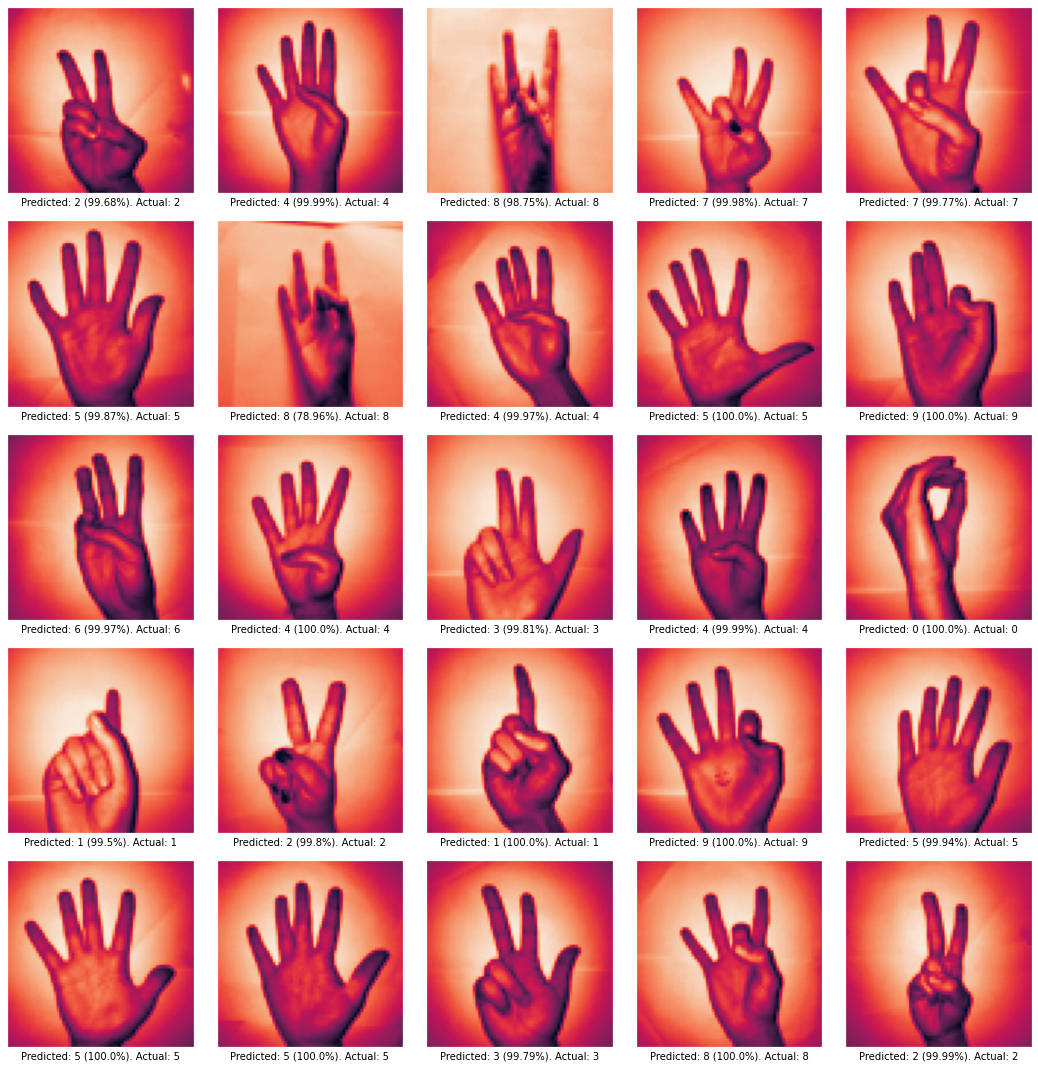

In [51]:
# Plot random sample to check predictions

plt.figure(figsize=(15,15))
nn = 25
for ii in range(0, nn):
    plt.subplot(5,5,ii+1)
    plt.xticks([])
    plt.yticks([])
    randno = random.randint(0, (len(X_test)-1))
    plt.imshow(X_test[randno])
    plt.tight_layout()
    if y_predict_labels[randno] == test_y[randno]:
        color = 'black'
    else:
        color = 'red'
    plt.xlabel('Predicted: ' + str(y_predict_labels[randno]) + ' (' +
              str(round(100*np.max(predIdxs[randno]), 2)) + "%). " +
               "Actual: " + str(test_y[randno]), color = color, fontsize = 10)

In [53]:
# save the model as .h5 to disk
model_path = os.getcwd()+"/model/sign_lang_model"
model.save(model_path + ".h5")  #h5 format

In [54]:
model.save(model_path)

2021-12-29 14:03:51.404717: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/user/AI_HandSign_Number/model/sign_lang_model/assets


In [57]:
## Loading the model from the saved location
loaded_model = tf.keras.models.load_model("model/sign_lang_model")

## check architecture
#loaded_model.summary()